In [ ]:
import requests
import csv

# Step 1: Download the file from the FTP link
url = "https://ftp.ncbi.nlm.nih.gov/pub/lu/tmVar3/tmVar3Corpus.txt"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Step 2: Read and parse the text file content
    text_data = response.text.splitlines()

    # Define the CSV header based on your data structure
    csv_header = ['ID', 'Title', 'Abstract', 'Gene', 'Mutation', 'Additional_Info']

    # Prepare a list to hold structured data
    structured_data = []

    # Step 3: Parse each line of the text data into a structured format
    for line in text_data:
        # Example line structure based on the data you provided
        parts = line.split('|')  # Assuming '|' is used as a delimiter
        if len(parts) >= 6:
            structured_data.append([parts[0], parts[1], parts[2], parts[3], parts[4], parts[5]])

    # Step 4: Write the structured data to a CSV file
    with open('tmVar3Corpus.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(csv_header)
        writer.writerows(structured_data)

    print("Data successfully written to tmVar3Corpus.csv")
else:
    print(f"Failed to download the file. HTTP Status code: {response.status_code}")


Data successfully written to tmVar3Corpus.csv


In [ ]:
import csv
import re

# Function to parse and restructure data
def parse_and_structure_data(input_file, output_file):
    # Read the input CSV file
    with open(input_file, mode='r', newline='', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        header = next(reader)  # Skip header

        # Open the output CSV file to write the structured data
        with open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
            writer = csv.writer(outfile)
            # Write the header for the structured output
            writer.writerow(["ID", "Title", "Abstract", "Gene", "Mutation", "Additional_Info"])

            # Process each row from the input CSV
            for row in reader:
                # Assuming the input CSV has the following structure based on your example:
                # ID | StartPos | EndPos | MutationDetails | Type | Mutation | AdditionalInfo
                # Example row: ['19429592', '984', '1000', 'p.S522fs', 'ProteinMutation', 'p', 'FS', 'S', '522', '525;CorrespondingGene:6103;VariantGroup:0']

                ID = row[0]
                StartPos = row[1]
                EndPos = row[2]
                MutationDetails = row[3]
                MutationType = row[4]
                MutationInfo = row[5]

                # Combine StartPos and EndPos for the Title
                Title = f"{StartPos}-{EndPos}"

                # Combine MutationDetails and MutationType for Abstract
                Abstract = f"{MutationDetails} {MutationType}"

                # Gene (extract from AdditionalInfo)
                # For example, if AdditionalInfo is '525;CorrespondingGene:6103;VariantGroup:0'
                AdditionalInfo = row[9] if len(row) > 9 else ''
                Gene = ''
                if 'CorrespondingGene' in AdditionalInfo:
                    match = re.search(r"CorrespondingGene:(\d+)", AdditionalInfo)
                    if match:
                        Gene = "Gene_" + match.group(1)

                # Create a structured row
                structured_row = [ID, Title, Abstract, Gene, MutationDetails, AdditionalInfo]

                # Write the structured data to the output CSV
                writer.writerow(structured_row)

# Provide the input and output file paths
input_csv = 'tmVar3Corpus.csv'  # Replace with your actual input CSV file path
output_csv = 'structured_output.csv'  # Replace with desired output CSV file path

# Call the function to process and restructure the data
parse_and_structure_data(input_csv, output_csv)


In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch
import re

# Load the Hugging Face pipeline for Zero-Shot classification
zero_shot_classifier = pipeline("zero-shot-classification")

# Function to get Hugging Face response for Zero-Shot classification
def get_huggingface_response(prompt, model="facebook/bart-large-mnli", temperature=0.7):
    result = zero_shot_classifier(prompt, candidate_labels=["correct", "incorrect", "complete", "incomplete", "comprehensive", "incomplete"])
    return result['scores'][0]  # Return the score for the most likely label

# Function to compute correctness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_correctness_score(description, disease_term, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate how similar the disease term is to the description
    zero_shot_prompt = f"Evaluate the correctness of the disease description in relation to the disease term. The description: '{description}' and the disease term: '{disease_term}'. Rate the correctness on a scale from 0 to 1."

    correctness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return correctness_score_zero_shot


# Function to compute completeness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_completeness_score(description, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate if the description covers all aspects of the disease
    zero_shot_prompt = f"Is the following disease description complete? Does it include key symptoms, diagnostic information, and relevant details about the disease? Describe any missing aspects. The description: '{description}'"

    completeness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return completeness_score_zero_shot


# Function to compute comprehensiveness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_comprehensiveness_score(description, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate the comprehensiveness of the description
    zero_shot_prompt = f"Is the following disease description comprehensive? Does it include symptoms, diagnostic tests, treatments, and all relevant details? Rate the comprehensiveness on a scale from 0 to 1. The description: '{description}'"

    comprehensiveness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return comprehensiveness_score_zero_shot


# Few-shot Prompting Example for Correctness, Completeness, and Comprehensiveness
def few_shot_prompt(prompt, model="gpt2"):
    # Example 1: Correctness
    example_1 = "Description: 'A condition characterized by joint pain and stiffness. Often causes inflammation.' Disease Term: 'Arthritis'. Correctness: 0.8"
    example_2 = "Description: 'A disorder affecting the nervous system with symptoms of paralysis and muscle weakness.' Disease Term: 'Multiple Sclerosis'. Correctness: 0.9"

    # Example 2: Completeness
    example_3 = "Description: 'A disease caused by the flu virus, characterized by fever, chills, sore throat, and fatigue.' Completeness: 0.8"
    example_4 = "Description: 'A chronic condition involving high blood sugar levels and insulin resistance.' Completeness: 0.9"

    # Example 3: Comprehensiveness
    example_5 = "Description: 'A condition that involves an autoimmune response that attacks the joints.' Comprehensiveness: 0.7"
    example_6 = "Description: 'A mental health condition characterized by persistent sadness, feelings of hopelessness, and a lack of interest in daily activities.' Comprehensiveness: 0.85"

    # Combine the examples and prompt
    few_shot_examples = "\n".join([example_1, example_2, example_3, example_4, example_5, example_6])

    prompt_with_few_shot = f"{few_shot_examples}\n\n{prompt}"

    # Use the GPT-2 model from Hugging Face for Few-Shot Prompting
    tokenizer = AutoTokenizer.from_pretrained(model)
    model = AutoModelForCausalLM.from_pretrained(model)

    inputs = tokenizer(prompt_with_few_shot, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=400, num_return_sequences=1, temperature=0.7)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the numerical score from the response
    match = re.search(r"(\d+\.\d+)", response)
    if match:
        return float(match.group(1))  # Return the extracted score
    else:
        return 0.0  # Return a default score in case no score is found


# Read the CSV file using pandas (replace 'your_file.csv' with the actual file path)
csv_file_path = 'structured_output.csv'  # Replace this with your actual CSV file path
df = pd.read_csv(csv_file_path)

# Initialize variables to accumulate scores for averaging
zero_shot_correctness_total = 0
zero_shot_completeness_total = 0
zero_shot_comprehensiveness_total = 0

few_shot_correctness_total = 0
few_shot_completeness_total = 0
few_shot_comprehensiveness_total = 0

# Evaluate the first few rows of the CSV file
num_rows = 7
for i in range(num_rows):
    description = df.iloc[i]['Abstract']  # Adjust the column name accordingly
    disease_term = df.iloc[i]['Title']  # Adjust the column name accordingly

    # Compute the scores using Zero-Shot and Few-Shot approaches

    # Zero-Shot Approach
    correctness_score_zero_shot = compute_correctness_score(description, disease_term)
    completeness_score_zero_shot = compute_completeness_score(description)
    comprehensiveness_score_zero_shot = compute_comprehensiveness_score(description)

    zero_shot_correctness_total += correctness_score_zero_shot
    zero_shot_completeness_total += completeness_score_zero_shot
    zero_shot_comprehensiveness_total += comprehensiveness_score_zero_shot

    print(f"Row {i+1} - Zero-Shot Correctness Score: {correctness_score_zero_shot}")
    print(f"Row {i+1} - Zero-Shot Completeness Score: {completeness_score_zero_shot}")
    print(f"Row {i+1} - Zero-Shot Comprehensiveness Score: {comprehensiveness_score_zero_shot}")

    # Few-Shot Approach
    few_shot_correctness_prompt = f"Evaluate the correctness of the disease description: '{description}' with the disease term: '{disease_term}'. Rate the correctness from 0 to 1."
    few_shot_completeness_prompt = f"Is the following disease description complete? Rate the completeness from 0 to 1. The description: '{description}'"
    few_shot_comprehensiveness_prompt = f"Evaluate if the description includes symptoms, diagnostic tests, and treatments. Rate the comprehensiveness from 0 to 1. The description: '{description}'"

    correctness_score_few_shot = few_shot_prompt(few_shot_correctness_prompt)
    completeness_score_few_shot = few_shot_prompt(few_shot_completeness_prompt)
    comprehensiveness_score_few_shot = few_shot_prompt(few_shot_comprehensiveness_prompt)

    few_shot_correctness_total += correctness_score_few_shot
    few_shot_completeness_total += completeness_score_few_shot
    few_shot_comprehensiveness_total += comprehensiveness_score_few_shot

    print(f"Row {i+1} - Few-Shot Correctness Score: {correctness_score_few_shot}")
    print(f"Row {i+1} - Few-Shot Completeness Score: {completeness_score_few_shot}")
    print(f"Row {i+1} - Few-Shot Comprehensiveness Score: {comprehensiveness_score_few_shot}")

# Calculate and print the average scores for Zero-Shot and Few-Shot
zero_shot_correctness_avg = zero_shot_correctness_total / num_rows
zero_shot_completeness_avg = zero_shot_completeness_total / num_rows
zero_shot_comprehensiveness_avg = zero_shot_comprehensiveness_total / num_rows

few_shot_correctness_avg = few_shot_correctness_total / num_rows
few_shot_completeness_avg = few_shot_completeness_total / num_rows
few_shot_comprehensiveness_avg = few_shot_comprehensiveness_total / num_rows

print(f"\nZero-Shot Average Correctness Score: {zero_shot_correctness_avg}")
print(f"Zero-Shot Average Completeness Score: {zero_shot_completeness_avg}")
print(f"Zero-Shot Average Comprehensiveness Score: {zero_shot_comprehensiveness_avg}")

print(f"\nFew-Shot Average Correctness Score: {few_shot_correctness_avg}")
print(f"Few-Shot Average Completeness Score: {few_shot_completeness_avg}")
print(f"Few-Shot Average Comprehensiveness Score: {few_shot_comprehensiveness_avg}")


No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Row 1 - Zero-Shot Correctness Score: 0.29803168773651123
Row 1 - Zero-Shot Completeness Score: 0.43319839239120483
Row 1 - Zero-Shot Comprehensiveness Score: 0.3038823902606964


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 1 - Few-Shot Correctness Score: 0.8
Row 1 - Few-Shot Completeness Score: 0.8
Row 1 - Few-Shot Comprehensiveness Score: 0.8
Row 2 - Zero-Shot Correctness Score: 0.2952217161655426
Row 2 - Zero-Shot Completeness Score: 0.4315648376941681
Row 2 - Zero-Shot Comprehensiveness Score: 0.2936191260814667


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 2 - Few-Shot Correctness Score: 0.8
Row 2 - Few-Shot Completeness Score: 0.8
Row 2 - Few-Shot Comprehensiveness Score: 0.8
Row 3 - Zero-Shot Correctness Score: 0.2908591032028198
Row 3 - Zero-Shot Completeness Score: 0.4338935613632202
Row 3 - Zero-Shot Comprehensiveness Score: 0.315182089805603


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 3 - Few-Shot Correctness Score: 0.8
Row 3 - Few-Shot Completeness Score: 0.8
Row 3 - Few-Shot Comprehensiveness Score: 0.8
Row 4 - Zero-Shot Correctness Score: 0.29334887862205505
Row 4 - Zero-Shot Completeness Score: 0.42660272121429443
Row 4 - Zero-Shot Comprehensiveness Score: 0.29178571701049805


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 4 - Few-Shot Correctness Score: 0.8
Row 4 - Few-Shot Completeness Score: 0.8
Row 4 - Few-Shot Comprehensiveness Score: 0.8
Row 5 - Zero-Shot Correctness Score: 0.2831295430660248
Row 5 - Zero-Shot Completeness Score: 0.42611852288246155
Row 5 - Zero-Shot Comprehensiveness Score: 0.29110854864120483


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 5 - Few-Shot Correctness Score: 0.8
Row 5 - Few-Shot Completeness Score: 0.8
Row 5 - Few-Shot Comprehensiveness Score: 0.8
Row 6 - Zero-Shot Correctness Score: 0.2832900583744049
Row 6 - Zero-Shot Completeness Score: 0.4350975751876831
Row 6 - Zero-Shot Comprehensiveness Score: 0.28496843576431274


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 6 - Few-Shot Correctness Score: 0.8
Row 6 - Few-Shot Completeness Score: 0.8
Row 6 - Few-Shot Comprehensiveness Score: 0.8
Row 7 - Zero-Shot Correctness Score: 0.2894665598869324
Row 7 - Zero-Shot Completeness Score: 0.4328386187553406
Row 7 - Zero-Shot Comprehensiveness Score: 0.30453547835350037


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Row 7 - Few-Shot Correctness Score: 0.8
Row 7 - Few-Shot Completeness Score: 0.8
Row 7 - Few-Shot Comprehensiveness Score: 0.8

Zero-Shot Average Correctness Score: 0.29047822100775583
Zero-Shot Average Completeness Score: 0.4313306042126247
Zero-Shot Average Comprehensiveness Score: 0.2978688265596117

Few-Shot Average Correctness Score: 0.7999999999999999
Few-Shot Average Completeness Score: 0.7999999999999999
Few-Shot Average Comprehensiveness Score: 0.7999999999999999


In [3]:
import pandas as pd
from tqdm import tqdm

# Function to extract unique pairs of Title and Abstract
def get_unique_pairs(df):
    unique_pairs = set()  # Store unique pairs in a set to avoid duplicates
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Entries"):
        pair = (row['Title'], row['Abstract'])
        unique_pairs.add(pair)
    return unique_pairs

# Function to calculate uniqueness and duplication scores for a dataset
def calculate_scores(df):
    unique_pairs = get_unique_pairs(df)
    total_entries = len(df)
    unique_pairs_count = len(unique_pairs)

    # Calculate scores
    uniqueness_score = unique_pairs_count / total_entries
    duplication_score = 1 - uniqueness_score  # Duplication score is the complement of uniqueness

    return uniqueness_score, duplication_score

# Load the dataset
dataset_path = 'structured_output.csv'
df = pd.read_csv(dataset_path)

# Calculate and print the scores for the dataset
uniqueness_score, duplication_score = calculate_scores(df)
print(f"Uniqueness Score: {uniqueness_score:.4f}")
print(f"Duplication Score: {duplication_score:.4f}")


Processing Entries: 100%|██████████| 37/37 [00:00<00:00, 4427.27it/s]

Uniqueness Score: 0.6757
Duplication Score: 0.3243


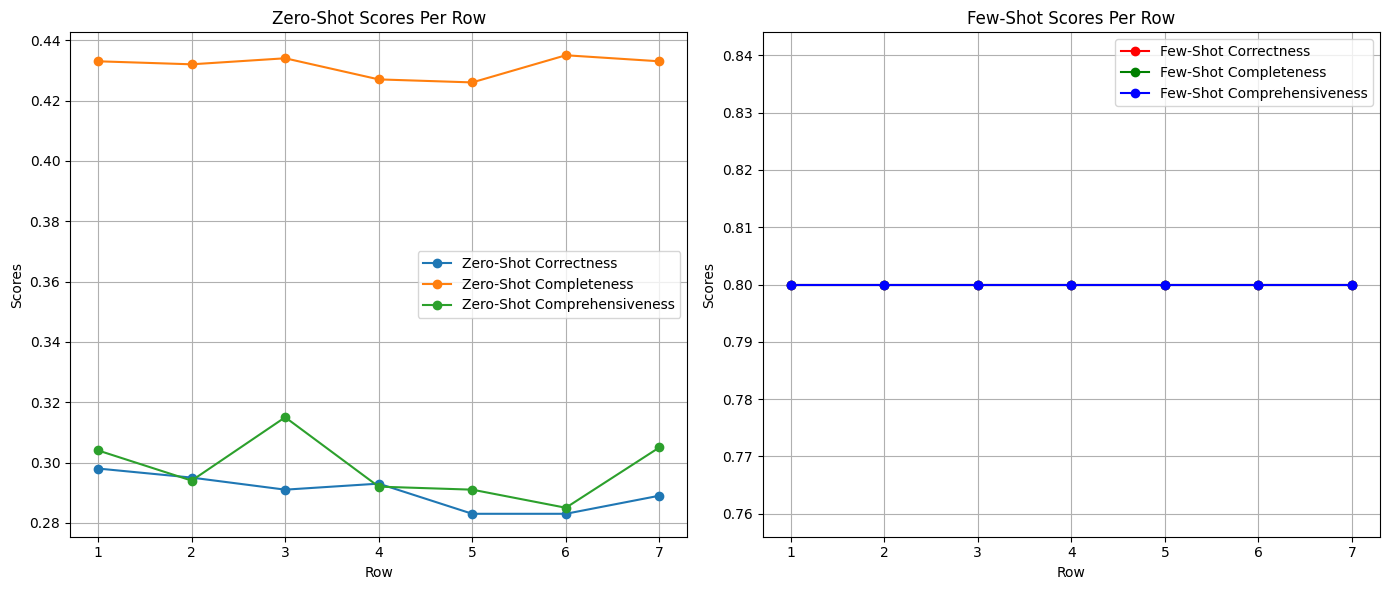

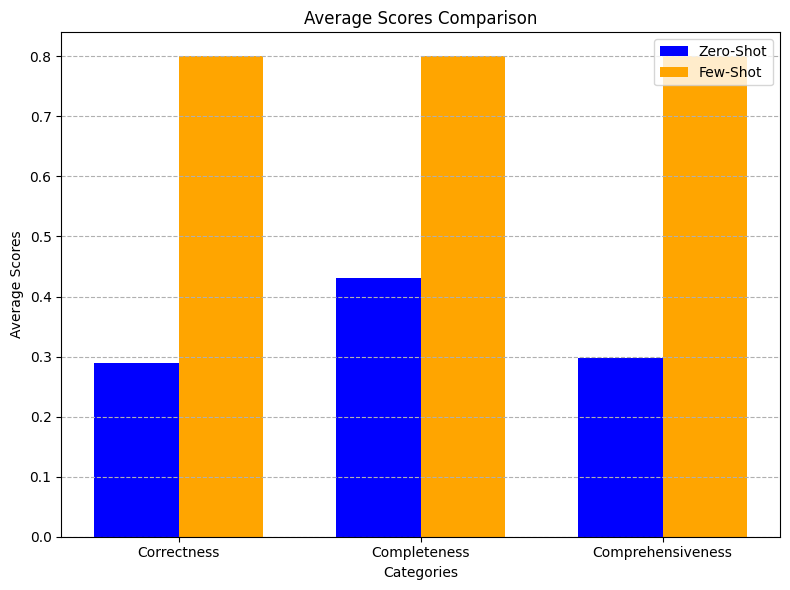

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
rows = np.arange(1, 8)  # Rows 1 to 7
zero_shot_correctness = [0.298, 0.295, 0.291, 0.293, 0.283, 0.283, 0.289]
zero_shot_completeness = [0.433, 0.432, 0.434, 0.427, 0.426, 0.435, 0.433]
zero_shot_comprehensiveness = [0.304, 0.294, 0.315, 0.292, 0.291, 0.285, 0.305]

few_shot_correctness = [0.8] * 7
few_shot_completeness = [0.8] * 7
few_shot_comprehensiveness = [0.8] * 7

# Averages
zero_shot_avg = [0.290, 0.431, 0.298]
few_shot_avg = [0.8, 0.8, 0.8]
categories = ['Correctness', 'Completeness', 'Comprehensiveness']

# Visualization: Per-Row Scores
plt.figure(figsize=(14, 6))

# Zero-Shot scores per row
plt.subplot(1, 2, 1)
plt.plot(rows, zero_shot_correctness, label="Zero-Shot Correctness", marker='o')
plt.plot(rows, zero_shot_completeness, label="Zero-Shot Completeness", marker='o')
plt.plot(rows, zero_shot_comprehensiveness, label="Zero-Shot Comprehensiveness", marker='o')
plt.title("Zero-Shot Scores Per Row")
plt.xlabel("Row")
plt.ylabel("Scores")
plt.xticks(rows)
plt.legend()
plt.grid()

# Few-Shot scores per row
plt.subplot(1, 2, 2)
plt.plot(rows, few_shot_correctness, label="Few-Shot Correctness", marker='o', color='r')
plt.plot(rows, few_shot_completeness, label="Few-Shot Completeness", marker='o', color='g')
plt.plot(rows, few_shot_comprehensiveness, label="Few-Shot Comprehensiveness", marker='o', color='b')
plt.title("Few-Shot Scores Per Row")
plt.xlabel("Row")
plt.ylabel("Scores")
plt.xticks(rows)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Visualization: Average Scores Comparison
plt.figure(figsize=(8, 6))
bar_width = 0.35
x = np.arange(len(categories))

plt.bar(x - bar_width / 2, zero_shot_avg, bar_width, label="Zero-Shot", color='blue')
plt.bar(x + bar_width / 2, few_shot_avg, bar_width, label="Few-Shot", color='orange')

plt.title("Average Scores Comparison")
plt.xlabel("Categories")
plt.ylabel("Average Scores")
plt.xticks(x, categories)
plt.legend()
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()
